# A/B Testing

In [1]:
import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import seaborn as sns

## Outcomes

- Describe what an A/B Test is:
    - When it is used
    - What forms it may take
- Conduct an A/B Test in Python using `scipy`


A/B Testing is really just a form of hypothesis testing applied to a business problem. And so it can take [many forms](https://en.wikipedia.org/wiki/A/B_testing).

The classic form of A/B Testing is exposing customers to two different versions of a website (the A and B versions) and then conducting a hypothesis test to see if their behavior is significantly different between the two versions.

Even limited to this context, there are [many](https://neilpatel.com/blog/19-obvious-ab-tests/) tests one might run!

We'll try a couple examples of A/B Testing here.

To start we'll try two examples with fake data:

## Example 1: Canadian Winter Temperatures

In [2]:
a1 = pd.read_csv('fake_data/a1.csv', usecols=['target'])
b1 = pd.read_csv('fake_data/b1.csv', usecols=['target'])

In [3]:
a1.head()

,target
0,-12.783261
1,-2.142397
2,13.996387
3,-9.040035
4,6.837523


In [4]:
b1.head()

,target
0,24.304128
1,-10.077538
2,19.751174
3,-9.126446
4,17.236564


### Kernel Density Plots

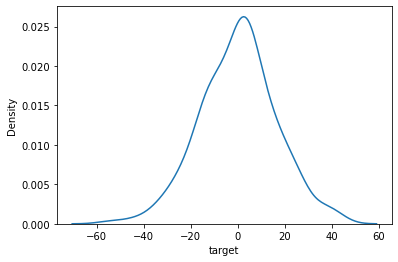

In [5]:
sns.kdeplot(a1['target']);

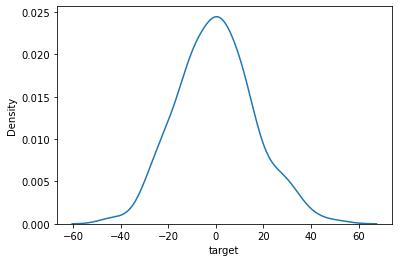

In [6]:
sns.kdeplot(b1['target']);

### Hypothesis Test

The data here represent average winter temperatures at various locations in Canada, and the question is whether the temperatures in Group A are lower than temperatures in Group B.

**Null hypothesis**: The temperatures in Group A are not lower than the temperatures in Group B.

**Alternative hypothesis**: The temperatures in Group A are lower than the temperatures in Group B.

### By Hand
First let's try this by hand, assuming a $t$-distribution, and setting an $\alpha$ threshold of 0.02:

We'll start by calculating the pooled variance:
- $\Large s^2_P=\frac{(n_1-1)s^2_1 - (n_2-1)s^2_2}{n_1+n_2-2}$.

In [7]:
var_pooled = ((len(a1)-1) * a1.var() - (len(b1)-1) * b1.var()) / (len(a1) + len(b1) - 2)
var_pooled

target   -3.60768
dtype: float64

Now we calculate the $t$-statistic:
- $\Large t=\frac{\bar{x_1} - \bar{x_2}}{s^2_P\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$

In [8]:
t = (a1.mean() - b1.mean()) / (var_pooled * np.sqrt(1/len(a1) + 1/len(b1)))
t

target   -0.88395
dtype: float64

And the critical $t$-stat is:

In [9]:
stats.t.ppf(0.99, df=len(a1)+len(b1)-2)

2.333859092543348

### In One Line!

In [10]:
stats.ttest_ind(a1, b1, equal_var=False).pvalue

array([0.84415484])

## Example 2: Online Sales

Now let's try a binomial A/B Test (where the variable of interest is binary). We can use [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test).

### Question

We have data about whether customers completed sales transactions, segregated by the type of ad banners to which the customers were exposed.

The question we want to answer is whether there was any difference in sales "conversions" between desktop customers who saw the sneakers banner and desktop customers who saw the accessories banner in the month of May 2019.

### Getting the Data

First let's download the data from [kaggle](https://www.kaggle.com/podsyp/how-to-do-product-analytics).

In [11]:
!pwd

/Users/jamesirving/Documents/GitHub/_COHORT_NOTES/022221FT/Online-DS-FT-022221-Cohort-Notes/Phase_2/topic_16_AB_testing/ds-ab_testing-main


In [ ]:
# !unzip /Users/dbraslow/Downloads/archive.zip

In [ ]:
# !mkdir data

In [ ]:
# !ls

In [ ]:
# !mv /Users/dbraslow/Downloads/product.csv data

Let's go ahead and amend the `.gitignore` file now so that we don't accidentally add the data to our next commit.

In [ ]:
# !(echo ""; echo "# data"; echo "product.csv") >> .gitignore

In [12]:
df = pd.read_csv('/Users/jamesirving/datasets/product.csv')

In [13]:
df.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471220 entries, 0 to 8471219
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   order_id      object
 1   user_id       object
 2   page_id       object
 3   product       object
 4   site_version  object
 5   time          object
 6   title         object
 7   target        int64 
dtypes: int64(1), object(7)
memory usage: 517.0+ MB


### EDA

Lets's look at the different banner types:

In [15]:
df['product'].value_counts()

clothes             1786438
company             1725056
sneakers            1703342
sports_nutrition    1634625
accessories         1621759
Name: product, dtype: int64

In [16]:
df.groupby('product')['target'].value_counts()

product           target
accessories       0         1577208
                  1           44551
clothes           0         1673723
                  1          112715
company           0         1725056
sneakers          0         1635623
                  1           67719
sports_nutrition  0         1610888
                  1           23737
Name: target, dtype: int64

Let's look at the range of time-stamps on these data:

In [17]:
df['time'].min()

'2019-01-01 00:00:03'

In [18]:
df['time'].max()

'2019-05-31 23:59:58'

Let's check the counts of the different site_version values:

In [19]:
df['site_version'].value_counts()

mobile     6088335
desktop    2382885
Name: site_version, dtype: int64

In [20]:
df['title'].value_counts()

banner_show     7393314
banner_click     829184
order            248722
Name: title, dtype: int64

In [21]:
df.groupby('title').agg({'target': 'mean'})

,target
title,
banner_click,0
banner_show,0
order,1


### Experimental Setup

We need to filter by site_version, time, and product:

In [22]:
df_AB = df[(df['site_version'] == 'desktop') &
           (df['time'] >= '2019-05-01') &
           ((df['product'] == 'accessories') | (df['product'] == 'sneakers'))].reset_index(drop = True)

In [23]:
df_AB.tail()

,order_id,user_id,page_id,product,site_version,time,title,target
218783,f549b8a88b84d5b6813bb98c03b3270a,f57ab001ccae51094cdbf91e6a7a1db8,07403df14c267a77b7df508eed9e651c,sneakers,desktop,2019-05-23 10:22:00,banner_show,0
218784,566828e3ea907d4966d4965b28265986,5df0d1240a575396e75223a589e44295,f2dff4a4f409d399398e583da973983f,accessories,desktop,2019-05-24 06:49:26,banner_show,0
218785,f37363d980d062d9ccdfd58f793a36c8,fd645f04aa9c16781d2173bcf38592dd,f10503fd6aa0473bad30f78150035a75,sneakers,desktop,2019-05-29 17:17:27,banner_show,0
218786,982c47ce571d715bd1e5ebcb185500f9,d73ee197a864f988f7edf1cc284c44c3,01f91b0ef0f8b9807232eb4e5a02babb,accessories,desktop,2019-05-27 18:50:51,banner_show,0
218787,70c275428b8d53eef294d0529253b694,59e736f90b5f8003072bf0eb271ddb86,7bc3a33568d00773d5b58d6c7348bf3e,accessories,desktop,2019-05-23 14:07:00,banner_show,0


### The Hypotheses

NULL: Customers who saw the sneakers banner were no more or less likely to buy than customers who saw the accessories banner.

ALTERNATIVE: Customers who saw the sneakers banner were more or less likely to buy than customers who saw the accessories banner.

### Setting a Threshold

We'll set a false-positive rate of $\alpha = 0.05$.

### Preparing Fisher's Test

Fisher's Test is an exact calculation of a $p$-value that requires four quantities: the respective numbers of 1's and 0's for each class.

In [24]:
df_A = df_AB[df_AB['product'] == 'accessories']
df_B = df_AB[df_AB['product'] == 'sneakers']

We calculate values in a 2x2 table: the numbers of people who did or did not submit orders, both for the accessories banner and thesneakers banner. 

In [25]:
accessories_orders = sum(df_A['target'])
sneakers_orders = sum(df_B['target'])

accessories_orders, sneakers_orders

(4649, 6868)

To get the numbers of people who didn't submit orders, we get the total number of people who were shown banners and then subtract the numbers of people who did make orders.

In [26]:
accessories_total = sum(df_A['title'] == 'banner_show')
sneakers_total = sum(df_B['title'] == 'banner_show')

accessories_no_orders = accessories_total - accessories_orders
sneakers_no_orders = sneakers_total - sneakers_orders

accessories_no_orders, sneakers_no_orders

(93562, 92492)

### Calculation

Fisher's Test tells us that the $p$-value corresponding to our distribution is given by:

$\Large p = \frac{(a+b)!(c+d)!(a+c)!(b+d)!}{a!b!c!d!n!}$

In [27]:
a = accessories_orders
b = sneakers_orders
c = accessories_no_orders
d = sneakers_no_orders

In [28]:
ab_choose_a = comb(a+b, a, exact=True)

In [29]:
cd_choose_c = comb(c+d, c, exact=True)

In [30]:
n_choose_ac = comb(a+b+c+d, a+c, exact=True)

In [31]:
p = ab_choose_a * cd_choose_c / n_choose_ac
p

3.849329970961971e-96

Comparing with `stats.fisher_exact()`:

In [32]:
stats.fisher_exact(np.array([[a, b], [c, d]]))

(0.6691661029944147, 2.2151768161436975e-95)

This extremely low $p$-value suggests that these two groups are genuinely performing differently. In particular, the desktop customers who saw the sneakers banner in May 2019 bought at a higher rate than the desktop customers who saw the accessories banner in May 2019.

## Exercise

Same question as before, but this time for April 2019 instead of May! Use a threshold of 0.05.